Show effectiveness of FastGradientMethod for generating minimal adv examples.
Using IBM ART (adversarial-robustness-toolbox). Check out the [source code and demo](https://github.com/IBM/adversarial-robustness-toolbox/tree/master/art) here.

This notebook is an example of using two tensorflow graphs together (the pre-processing graph is identity here) with parameter loading.

In [1]:
import glob
import os

import numpy as np
import tensorflow as tf
import pydub
import librosa
import matplotlib.pyplot as plt
import matplotlib as mpl

from art.attacks.evasion import FastGradientMethod, AutoProjectedGradientDescent
from art.estimators.classification import TensorFlowClassifier

import warnings
warnings.filterwarnings('ignore')
# import spec2audio as sta
from IPython.display import Audio

In [2]:
plt.style.use('ggplot')

In [3]:
from augment_audio import scale_to_peak_windowed_dBFS
from util.ft import unnormalize_0_1

### 0. Read speech examples

In [4]:
TF_RECORD_DIR = '/scratch1/ilya/locDoc/data/alexa/v7.15/val_19680_positive'
tfrecord_files = glob.glob(os.path.join(TF_RECORD_DIR, '*.tfrecord'))
tfrecord_file = tfrecord_files[0]
mean = 0.3715735405001496
std_dev = 0.2031791745456392

In [7]:
def prep(S):
    S = S - mean
    S = S / std_dev
    return S

def unprocS(S):
    S = S * std_dev
    S = S + mean
    return S**(1/0.3)

In [6]:
spec_h = 257 # 80
# set some variables that are relavant to the network
# network_example_length = 19840
# hop_length = 160

examples = []
specs = []
spec_labs = []
limit = 100

# for tfrecord_file in tfrecord_files_val:
for i, example in enumerate(tf.python_io.tf_record_iterator(tfrecord_file)):
    if i < 20:
        continue
    eg_np = tf.train.Example.FromString(example)
    audio_segment = pydub.AudioSegment(
        eg_np.features.feature["audio"].bytes_list.value[0], 
        frame_rate=16000,
        sample_width=2, 
        channels=1
    )
    y = audio_segment.get_array_of_samples()
    examples.append(y)

    spec = eg_np.features.feature["spectrogram"].float_list.value
    spec = np.array(spec).reshape(spec_h,-1)  
    specs.append(spec)
    
    spec_labs.append(eg_np.features.feature["spectrogram_label"].int64_list.value)
    if i > limit:
        break

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [8]:
examples = np.array(examples)
specs = np.array(specs, dtype=np.float32)
spec_labs = np.array(spec_labs)
print(examples.shape)
print(specs.shape)

(52, 19680)
(52, 257, 124)


In [9]:
min_input_value, max_input_value = specs.min(), specs.max()

In [10]:
sound_i = 2
Audio(examples[sound_i], rate=16000)

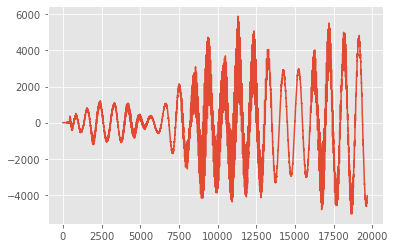

In [11]:
# sound_i += 1
plt.plot(examples[sound_i])

### 1. Slice the training example to feed into a network (of size 31)

### Get audio

In [13]:
n_fft = 512
hop_length = 160
win_length = 400

y = examples[sound_i] / 2**15
yp = np.pad(y, int(n_fft // 2), mode='reflect')

In [14]:
batch_item_length = n_fft-hop_length + hop_length*31
n_items_in_y = (len(yp) - batch_item_length) // hop_length

batched_input = []
batched_labels = spec_labs[sound_i,21:-10]
for i in range(n_items_in_y):
    start = i*hop_length
    end = start + batch_item_length
    batched_input.append(yp[start:end])

### Run preprocessing on audio, piece by piece

In [17]:
from util.librosa import librosa_window_fn

In [18]:
def mywindow_fn(argi, dtype):
    """
    argi is the length of the window that is returned. In this case it is
    n_fft. The window returned will be a win_length window zero padded to
    be n_fft long.
    """
    del argi
    return tf.convert_to_tensor(librosa_window_fn(win_length, n_fft), dtype=dtype)

In [19]:
input_spec = tf.placeholder(tf.float32, shape=(None,batch_item_length))
spec = tf.signal.stft(
    input_spec,
    frame_length=n_fft,
    frame_step=hop_length,
    fft_length=n_fft,
    window_fn=mywindow_fn,
    pad_end=False,
    name='STFT'
)
spec = tf.abs(spec)
# Stevens's power law for loudness
spec = spec**0.3
spec = tf.transpose(spec, perm=[0,2,1], name='spec_from_time')

In [20]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    feed_dict = {input_spec: batched_input}
    batched_input_from_audio = sess.run(spec, feed_dict)

### Compare with spectrogram from tfrecord

In [21]:
batched_input_from_tfrecord = []
batched_input_from_tfrecord_labels = []
for i in range(n_items_in_y):
    batched_input_from_tfrecord.append(specs[sound_i][:,i:(i+31)])
    batched_input_from_tfrecord_labels.append(spec_labs[sound_i][i+20])

In [22]:
batched_input_from_tfrecord = np.array(batched_input_from_tfrecord)

### Compare

In [24]:
(batched_input_from_tfrecord - batched_input_from_audio).mean()

-1.5125005e-05

## 2. Load wake word detection model

When loading another model, jupyter Kernel restart seems to be neccessary. `sess.close()` is not enough

In [25]:
with tf.Graph().as_default() as g_1:
    model_dir = '/scratch0/ilya/locDownloads/temp_7.15_model/baseline_tfspecv715_bs64_trial2/export/best_loss_exporter/1600571029/'
    with tf.compat.v1.Session(graph=g_1) as sess:
        model = tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], model_dir)
        predictor = tf.contrib.predictor.from_saved_model(model_dir)
        
        signature = model.signature_def
        signature_key = "serving_default"
        input_key = "spectrograms"
        output_key = "logits"

        x_tensor_name = signature[signature_key].inputs[input_key].name
        y_tensor_name = signature[signature_key].outputs[output_key].name

        input_ph = sess.graph.get_tensor_by_name(x_tensor_name)
        logits = sess.graph.get_tensor_by_name(y_tensor_name)
        flat_logits = tf.reshape(logits, [-1,3], name='flat_logits') # just gets rid of middle time dimension which is equal to 1 in the output 31 case
        
        saver = tf.train.Saver()
        saver.save(sess, "/scratch0/ilya/locDownloads/temp3/model_resave.ckpt")

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from /scratch0/ilya/locDownloads/temp_7.15_model/baseline_tfspecv715_bs64_trial2/export/best_loss_exporter/1600571029/variables/variables
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Restoring parameters from /scratch0/ilya/locDownloads/temp_7.15_model/baseline_tfspecv715_bs64_trial2/export/best_loss_exporter/1600571029/variables/variables


In [26]:
with tf.Graph().as_default() as g_2:
    input_alt_placeholder = tf.placeholder(tf.float32, shape=(None, 257, 31), name='time_input')
    
    output = tf.identity(input_alt_placeholder, name='spec_from_time')
    

In [27]:
from tensorflow.python.framework import meta_graph

In [28]:
g_combined = tf.get_default_graph()
combined_sess = tf.Session(graph=g_combined)
combined_input = tf.placeholder(tf.float32, shape=(None, 257, 31), name='time_input')

meta_graph2 = tf.train.export_meta_graph(graph=g_2)
meta_graph.import_scoped_meta_graph(meta_graph2, input_map={'time_input': combined_input}, import_scope='g_2')
out1 = g_combined.get_tensor_by_name('g_2/spec_from_time:0')

meta_graph1 = tf.train.export_meta_graph(graph=g_1)
new_saver = meta_graph.import_scoped_meta_graph(meta_graph1, input_map={x_tensor_name: out1}, import_scope=None)

out_final = g_combined.get_tensor_by_name('flat_logits:0')

labels_ph = tf.placeholder(tf.int32, shape=[None, 3])
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=out_final, labels=labels_ph))

restorer = tf.train.Saver()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [29]:
# ART library wrapper around the tensorflow model
# combined_sess = tf.Session(graph=g_combined)
classifier = TensorFlowClassifier(
    clip_values=(min_input_value, max_input_value),
    input_ph=combined_input,
    output=out_final,
    labels_ph=labels_ph,
    loss=loss_op,
    learning=None,
    sess=combined_sess,
    preprocessing_defences=[],
)

In [30]:
combined_sess.run(tf.global_variables_initializer())

In [31]:
restorer.restore(combined_sess, "/scratch0/ilya/locDownloads/temp3/model_resave.ckpt")

INFO:tensorflow:Restoring parameters from /scratch0/ilya/locDownloads/temp3/model_resave.ckpt


## 3. Evaluate the ART classifier on benign val examples

In [32]:
predictions = classifier.predict(prep(batched_input_from_audio))

In [35]:
labels = np.array(batched_input_from_tfrecord_labels)
labels = np.array(batched_labels)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

In [36]:
mask_acc = (np.argmax(predictions, axis=1) == (labels+1)).sum() / len(labels)
detection_acc = ((np.argmax(predictions, axis=1) == 2) & (labels == 1)).sum() / (labels == 1).sum()
other_acc = ((np.argmax(predictions, axis=1) != 2) & (labels != 1)).sum() / (labels != 1).sum()
print('Mask acc: %.4f, Detection acc: %.4f, Non-wake acc: %.4f' % (mask_acc, detection_acc, other_acc))

Mask acc: 0.4946, Detection acc: 0.3333, Non-wake acc: 1.0000


## 4. Generate adversarial test examples

### 4.A Ready data for adv examples

In [18]:
# keep a few
num_egs = 32
batched_subset = batched_input[:num_egs]
labels_subset = labels[:num_egs]

In [19]:
# or keep them all
batched_subset = batched_input
labels_subset = labels

Make some targeted bad labels for generating the adv examples

If you set targeted=False, then you should provide ground truth labels to attack.generate

If you set targeted=True, then you should proved the desired bad labels to attack.generate

In [20]:
# create bad labels
# in tfrecords: -1 is other speech. +1 is Keyword. 0 is silence.
# OR thinking about it as indexes, which is relevant for the NN:
# originally 0 is other speech. 2 is Keyword. 1 is silence.

# Flip WW speech to other speech and vice versa, we do: 2->0, 0->2
bad_labels = labels_subset + 1
bad_labels = (bad_labels == 2).astype(int)*0 + (bad_labels == 0).astype(int)*2 + (bad_labels == 1).astype(int)

# All speech is other speech, 2->0
bad_labels = labels_subset + 1
bad_labels = (bad_labels == 2).astype(int)*0 + (bad_labels == 0).astype(int)*0 + (bad_labels == 1).astype(int)

### 4.B Make Adv examples

In [21]:
# Fast Gradient Method
# TODO pick epsilon by SNR, see role of radius here: https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/307f7c9ec255c9c3594a9e57c82a2b9064c69843/art/utils.py#L195
eps = 10
eps_step=0.1
attack = FastGradientMethod(estimator=classifier, norm=2, targeted=True, eps=eps, eps_step=eps_step)
adv_egs = attack.generate(x=batched_subset, y=bad_labels)

FGD with l2 norm, and (eps, eps_step) of (10, 0.1) is working well at targeting 100% other speech. SNR at 20. The perturbation when isolated sounds a little like the speech, mostly like the noise, though you couldn't tell from the spectrogram.

In [679]:
# Auto-PGD
eps = 2.0
eps_step=0.1
attack = AutoProjectedGradientDescent(
                    estimator=classifier,
                    norm=np.inf,
                    eps=eps,
                    eps_step=eps_step,
                    max_iter=500,
                    targeted=True,
                    nb_random_init=5,
                    batch_size=32,
                    loss_type="difference_logits_ratio",
                )
adv_egs = attack.generate(x=batched_subset, y=bad_labels) #  y=labels_subset)#

Strugging to get Auto-PGD to work, tried:
- l_inf with (1, 0.1), 250 itr, cross_entropy and difference_logits_ratio
- l_2 and targeted never seems to work. Tried with (10,0.1), 250 itr, cross_entropy and difference_logits_ratio
- l_inf, targeted=False, and difference_logits_ratio always flips

One annoying thing is that Auto-PGD will ignore any examples where the output is equal to the target. So if targeted=True it does nothing where it meets the target. If targeted=False it does nothing where it gets the answer wrong. If you pass in no labels, it always does something, but it changes its own output.

Problem is we divide the signal into quarters. 

In [579]:
len(adv_egs)

32

## 5. Evaluate on adversarial val example

In [22]:
predictions = classifier.predict(batched_subset)

In [23]:
print('Before')
mask_acc = (np.argmax(predictions, axis=1) == (labels_subset+1)).sum() / len(labels_subset)
detection_acc = ((np.argmax(predictions, axis=1) == 2) & (labels_subset == 1)).sum() / (labels_subset == 1).sum()
other_acc = ((np.argmax(predictions, axis=1) != 2) & (labels_subset != 1)).sum() / (labels_subset != 1).sum()
print('Mask acc: %.4f, Detection acc: %.4f, Non-wake acc: %.4f' % (mask_acc, detection_acc, other_acc))

Before
Mask acc: 0.5762, Detection acc: 0.2593, Non-wake acc: 1.0000


In [24]:
orig_pred_class = np.argmax(predictions.copy(), axis=1)

predictions = classifier.predict(adv_egs)

adv_pred_class = np.argmax(predictions.copy(), axis=1)
flipped = (orig_pred_class != adv_pred_class).sum()
print('Changed %i/%i predictions, %.2f perc' % (flipped, len(adv_pred_class), 100*flipped / len(adv_pred_class)))

Changed 68/328 predictions, 20.73 perc


In [25]:
print('After')
mask_acc = (np.argmax(predictions, axis=1) == (labels_subset+1)).sum() / len(labels_subset)
detection_acc = ((np.argmax(predictions, axis=1) == 2) & (labels_subset == 1)).sum() / (labels_subset == 1).sum()
other_acc = ((np.argmax(predictions, axis=1) != 2) & (labels_subset != 1)).sum() / (labels_subset != 1).sum()
print('Mask acc: %.4f, Detection acc: %.4f, Non-wake acc: %.4f' % (mask_acc, detection_acc, other_acc))

After
Mask acc: 0.5061, Detection acc: 0.0000, Non-wake acc: 1.0000


## 6. Listen to adversarial val example

In [26]:
# unbatch the adversarial version
num_frames_per_eg = (specs.shape[-1]//31)
num_full_egs = len(adv_egs) // num_frames_per_eg
unbatched_adv = np.zeros_like(specs[:num_full_egs])
for i in range(num_full_egs):
    single_eg = np.zeros_like(specs[i])
    for j in range(num_frames_per_eg):
        unbatched_adv[i, :, (j*31):((j+1)*31)] = adv_egs[i*4 + j]

In [27]:
sound_i = 2

In [28]:
snr = 10*np.log10( ( unprocS(specs[sound_i])**2 ).mean() / (( unprocS(unbatched_adv[sound_i]) - unprocS(specs[sound_i]) )**2).mean() )
print('SNR is %.2f' % snr)

SNR is 21.01


In [42]:
# get original phase to use for reconstruction
samples = scale_to_peak_windowed_dBFS(examples[sound_i], target_dBFS=-15.0, rms_window=5)
orig_stft = librosa.core.stft(samples,
        win_length=16000//40,
        hop_length=160,
        n_fft=512)
orig_phase = np.angle(orig_stft)

(-0.5, 123.5, 256.5, -0.5)

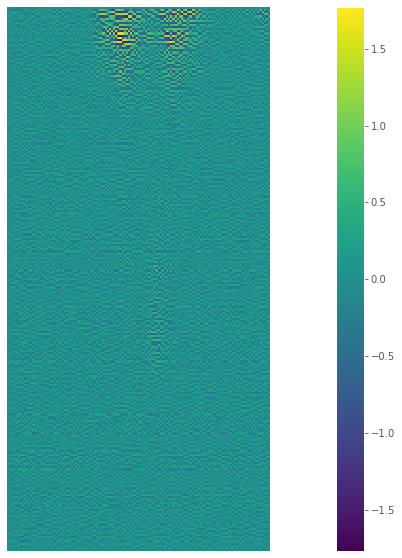

In [130]:
fig = plt.figure(figsize=(24,10))

data = np.imag(orig_stft)
sgn = np.sign(data)
# data = (data - data.mean() ) / data.std()
# data = np.unwrap(data, axis=1)
data = np.abs(data)**0.3
data = data * sgn

im = plt.imshow((data), vmin=data.min(), vmax=data.max())
plt.colorbar(im)
plt.axis('off')

In [132]:
np.stack([np.real(orig_stft), np.imag(orig_stft)], axis=-1).shape

(257, 124, 2)

In [120]:
sgn.shape

(257, 124)

In [30]:
# reconstruct clean (just to check reconstruction method)
# compare with Audio(examples[sound_i], rate=16000) above
mag = unprocS(specs[sound_i])
clean_stft = mag * np.exp(1.j * orig_phase)
clean_sound = librosa.core.istft(clean_stft,
        win_length=16000//40,
        hop_length=160)
Audio(clean_sound, rate=16000)

In [31]:
mag = unprocS(unbatched_adv[sound_i])
adv_stft = mag * np.exp(1.j * orig_phase)
adv_sound = librosa.core.istft(adv_stft,
        win_length=16000//40,
        hop_length=160)
print('Max is: %f' % adv_sound.max())
Audio(adv_sound, rate=16000)

Max is: 0.182228


In [32]:
err_sound = adv_sound - clean_sound
print('Max is: %f' % err_sound.max())
Audio(err_sound, rate=16000)

Max is: 0.010443


Text(0.5, 1.0, 'Original waveform (black) with adv noise (yellow)')

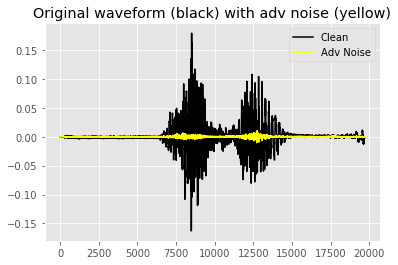

In [33]:
plt.figure()
plt.plot(clean_sound, color='black')
plt.plot(err_sound, color='yellow')
plt.legend(['Clean', 'Adv Noise'])
plt.title('Original waveform (black) with adv noise (yellow)')

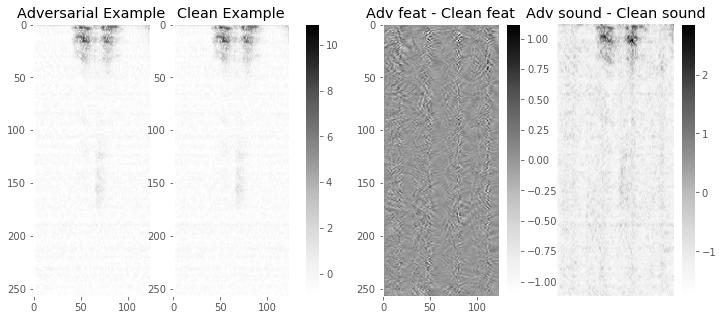

In [41]:
# Greys is a color map for: black hot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(12,5))
ax1.imshow( unbatched_adv[sound_i], aspect='auto', cmap='Greys', vmin=min_input_value, vmax=max_input_value)
ax1.set_title("Adversarial Example")
ax1.grid(False)
im = ax2.imshow( specs[sound_i], aspect='auto', cmap='Greys', vmin=min_input_value, vmax=max_input_value)
ax2.set_title("Clean Example")
ax2.grid(False)

abs_diff = unbatched_adv[sound_i] - specs[sound_i] 
im3 = ax3.imshow( abs_diff, aspect='auto', cmap='Greys', vmin=abs_diff.min(), vmax=abs_diff.max())
ax3.set_title("Adv feat - Clean feat")
ax3.grid(False)

err_stft = librosa.core.stft(err_sound,
        win_length=16000//40,
        hop_length=160,
        n_fft=512)
err_feat = (np.abs(err_stft)**0.3 - mean)/ std_dev
im4 = ax4.imshow( err_feat, aspect='auto', cmap='Greys', vmin=err_feat.min(), vmax=err_feat.max())
ax4.set_title("Adv sound - Clean sound")
ax4.grid(False)
ax4.axis('off')

cax,kw = mpl.colorbar.make_axes([ax for ax in (ax1, ax2)])
plt.colorbar(im, cax=cax, **kw)

cax,kw = mpl.colorbar.make_axes([ax3])
plt.colorbar(im3, cax=cax, **kw)

cax,kw = mpl.colorbar.make_axes([ax4])
plt.colorbar(im4, cax=cax, **kw)

## Take the particular sound and pass every frame through

In [35]:
eg_framewise = []
eg_framewise_labels = []
for j in range(specs.shape[-1] - 30):
    start = j
    end = (j+31)
    eg_framewise.append(unbatched_adv[sound_i,:,start:end])
    eg_framewise_labels.append(spec_labs[sound_i,start+20])
eg_framewise = np.array(eg_framewise)
eg_framewise_labels = np.array(eg_framewise_labels)
print(eg_framewise.shape)

(94, 257, 31)


In [36]:
adv_predictions = classifier.predict(eg_framewise)

In [37]:
eg_framewise = []
for j in range(specs.shape[-1] - 30):
    start = j
    end = (j+31)
    eg_framewise.append(specs[sound_i,:,start:end])
eg_framewise = np.array(eg_framewise)
eg_framewise_labels = np.array(eg_framewise_labels)
print(eg_framewise.shape)

(94, 257, 31)


In [38]:
clean_predictions = classifier.predict(eg_framewise)

Text(0.5, 1.0, 'True, Pred Clean, and Pred Adv labels')

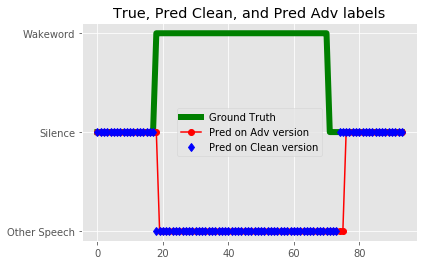

In [39]:
plt.figure()
plt.plot(eg_framewise_labels, '-', color='g', linewidth=6)
plt.plot(np.argmax(adv_predictions, axis=1)-1, '-o', color='r')
plt.plot(np.argmax(clean_predictions, axis=1)-1, 'd', color='b')
plt.yticks([1,0,-1], labels=['Wakeword', 'Silence', 'Other Speech'])
plt.legend(['Ground Truth', 'Pred on Adv version', 'Pred on Clean version'])
plt.title('True, Pred Clean, and Pred Adv labels')


Even though we constructed the adv audio based on 4 segments from the raw audio (at a hop size of 31), using a hop size of 1 to get 94 segments from the adversarial audio (hop size of 1) yields an incorrect lab

In [719]:
# save this example
out_path = '/scratch1/ilya/locDoc/experiments/adv_egs'
fname = 'fgd_adv_eg_%i.npz' % sound_i
np.savez(os.path.join(out_path, fname), adv_feat=unbatched_adv[sound_i], clean_feat=specs[sound_i], true_labels=eg_framewise_labels)